In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pymatching
import stim

circ_path = "circuits/"
plot_path = "plots/"

# Just as an archive/ comparison for my generalised code

# 1. Try for steane typ QEC code

Using a surface 17 code of distance 3.

# Questions 

for general state I should add the second set of stabilizers to the general qubit

is this already circuit-level noise? (errors after each gate?)
+ code-capacity model  (just physical dataqubits fail?)
+ phenomenological noise model (stabilizer can fail with fixed prob?)



In [22]:
# Set of function to construct a surface 17 code
minimal_amount_qubits = True 
# if set to false, the stabilizers qubits that are not used will still be there 
# useful if I change the way I want to compute

def generate_qubit_indices(
        circuit,
        gen_x_stabilizer:bool=True, 
        gen_z_stabilizer:bool=True,
        ):
    """
    We are starting from the last used qubit and generate the indices of:
    9 data qubits 
    4 Z measure qubits
    4 X measure qubits
    and returns those as a dict
    """
    if not minimal_amount_qubits:
        gen_x_stabilizer = True
        gen_z_stabilizer = True 

    data_qubits = np.arange(circuit.num_qubits, circuit.num_qubits + 9) #TODO number needs to depend on distance!
    log_qubit_indices = {
        "data": data_qubits,
        }
    circuit.append("R", data_qubits)
 
    if gen_z_stabilizer:
        Z_measure_qubits = np.arange(circuit.num_qubits,circuit.num_qubits + 4)#TODO number needs to depend on distance!
        log_qubit_indices.update({ 
            "Z_measure": Z_measure_qubits,
        })
        circuit.append("R", Z_measure_qubits)

    if gen_x_stabilizer:
        X_measure_qubits = np.arange(circuit.num_qubits,circuit.num_qubits + 4)#TODO number needs to depend on distance!
        log_qubit_indices.update({ 
            "X_measure": X_measure_qubits,
        })
        circuit.append("R", X_measure_qubits)
    circuit.append("TICK")

    return circuit, log_qubit_indices 

#TODO these constants are not easily extenible for higher distances 
# OR are they?!
Z_stabilizers = [
    [1,0,0,1,0,0,0,0,0],
    [0,0,0,1,1,0,1,1,0],
    [0,1,1,0,1,1,0,0,0],
    [0,0,0,0,0,1,0,0,1]
    ]
X_stabilizers = [
    [0,1,1,0,0,0,0,0,0],
    [1,1,0,1,1,0,0,0,0],
    [0,0,0,0,1,1,0,1,1],
    [0,0,0,0,0,0,1,1,0]
    ]

def add_stabilizer(
        circuit, 
        gen_x_stabilizer=True, 
        gen_z_stabilizer=True, 
        log_qubit_indices=None,
        ):
    """
    TODO: generalize for higher distance surface codes
    Adds a surface 17 stabilizer qubit to the circuit, with the given qubits
    with the option to turn off the not needed stabilizer qubits
    """
    if not log_qubit_indices:
        circuit, log_qubit_indices = generate_qubit_indices(circuit,gen_x_stabilizer,gen_z_stabilizer)
    data_qubits = log_qubit_indices["data"]

    if gen_z_stabilizer:
        Z_measure_qubits = log_qubit_indices["Z_measure"]
        # Z stabilizers: C(data)NOT(measure)
        for i,stabilizer in enumerate(Z_stabilizers):
            for j in np.argwhere(np.array(stabilizer)[:] == 1).ravel():
                # CxNOTy (of the list) "CNOT",[x,y]
                circuit.append("CNOT",[data_qubits[j],Z_measure_qubits[i]])
        circuit.append("MR", Z_measure_qubits)
        circuit.append("TICK")

    if gen_x_stabilizer:
        X_measure_qubits = log_qubit_indices["X_measure"]
        # X stabilizers: H(measure) C(measure)NOT(data) H(measure)
        circuit.append("H",X_measure_qubits)
        circuit.append("TICK")
        for i,stabilizer in enumerate(X_stabilizers):
            for j in np.argwhere(np.array(stabilizer)[:] == 1).ravel():
                circuit.append("CNOT",[X_measure_qubits[i],data_qubits[j]])
        circuit.append("TICK")
        circuit.append("H",X_measure_qubits)
        circuit.append("MR", X_measure_qubits)
        circuit.append("TICK")
    return circuit,  log_qubit_indices


In [23]:
# Function to add the auxilliary qubits needed in steane code to the code 
def add_aux_0_qubit(circuit, general_qubit):
    measurements_before_aux_0 = circuit.num_measurements
    # initalize aux qubit
    circuit, aux_0_qubit = add_stabilizer(circuit, gen_z_stabilizer=False)
    circuit.append("TICK")
    # entangle aux qubit 
    for i, _ in enumerate(general_qubit["data"]):
            circuit.append(
                "CNOT",
                [aux_0_qubit["data"][i],general_qubit["data"][i]],
                tag="entangle_CNOT",
            )
    circuit.append("TICK")
    # measure aux qubit 
    circuit.append("H",aux_0_qubit["data"])
    circuit.append("MR",aux_0_qubit["data"])
    circuit.append("TICK")
    # Set up Detectors 
    # They have to be deterministic! (XORing each input) 
    # encoding parity =(needs to be) measured parity [eg: rec(0) + rec(4) = rec(9) + rec(10)] => detector(0,4,9,10)
    x = measurements_before_aux_0
    detection_sets_aux_0 = [
        [0,0+x,5+x,6+x], 
        [1,1+x,4+x,5+x,7+x,8+x], 
        [2,2+x,8+x,9+x,11+x,12+x],
        [3,3+x,10+x,11+x],
    ]
    del x # cleanup the temp variable
    for i, set in enumerate(detection_sets_aux_0):
        rel_index = [x - circuit.num_measurements for x in set]
        circuit.append("DETECTOR",
        [stim.target_rec(x) for x in rel_index]
                                ) 
    circuit.append("TICK")
    return circuit, aux_0_qubit

def add_aux_p_qubit(circuit, general_qubit):
    measurements_before_aux_p = circuit.num_measurements
    # initialize aux qubit
    circuit, aux_p_qubit = generate_qubit_indices(circuit, gen_x_stabilizer=False)
    circuit.append("H",aux_p_qubit["data"]) # initalize in |+>-state
    circuit.append("TICK")
    circuit, _, = add_stabilizer(
        circuit, 
        gen_x_stabilizer=False, 
        log_qubit_indices=aux_p_qubit
        )
    circuit.append("TICK")
    # entangle aux qubit
    for i, _ in enumerate(general_qubit["data"]):
        circuit.append(
            "CNOT",
            [general_qubit["data"][i],aux_p_qubit["data"][i]],
            tag="entangle_CNOT",
        )
    circuit.append("TICK")
    # measure aux qubit
    circuit.append("MR",aux_p_qubit["data"])
    # Set up Detectors
    x = measurements_before_aux_p
    detection_sets_aux_p = [
        # TODO this need an distant agnostic approach
        [0+x,4+x,7+x], 
        [1+x,7+x,8+x,10+x,11+x], 
        [2+x,5+x,6+x,8+x,9+x],
        [3+x,9+x,12+x],
    ]
    del x 
    for i, set in enumerate(detection_sets_aux_p):
        rel_index = [x - circuit.num_measurements for x in set]
        circuit.append(
            "DETECTOR",
            [stim.target_rec(x) for x in rel_index]
        ) 
    circuit.append("TICK")
    return circuit, aux_p_qubit, detection_sets_aux_p

In [24]:
def construct_steane_circuit(
                       aux_p_qubit_used=True,
                       aux_0_qubit_used=True,
                       basic_errors=False,
                       noise=0, #TODO move noise to a different function 
                       reverse_order = False,
                       final_detectors = True,
                       ):
    # surface_code = True if I just want to simulate a surface 17 code
    steane_circuit = stim.Circuit()
    # generate indices & initialize qubits
    steane_circuit, general_qubit = add_stabilizer(steane_circuit, gen_z_stabilizer=False)

    if  basic_errors:
        # Add basic errors
        if aux_0_qubit_used:
            steane_circuit.append("Z_ERROR",general_qubit["data"],noise)
        if aux_p_qubit_used:
            steane_circuit.append("X_ERROR",general_qubit["data"],noise)

    if aux_0_qubit_used and reverse_order:
        steane_circuit, _ = add_aux_0_qubit(steane_circuit, general_qubit)

    if aux_p_qubit_used:
        steane_circuit, _, detection_sets_aux_p = add_aux_p_qubit(steane_circuit, general_qubit) 

    if aux_0_qubit_used and not reverse_order:
        steane_circuit, _ = add_aux_0_qubit(steane_circuit, general_qubit) 

    # measure general qubit
    measurements_before_final_measurment = steane_circuit.num_measurements
    steane_circuit.append(
        "M",
        general_qubit["data"],
        tag="final_data",
        )

    if final_detectors:
        # construct detector based on the data measurements
        #TODO construct this distance agnostic
        detection_sets_final_measurement = [ 
            [0,3],  
            [3,4,6,7],
            [1,2,4,5],
            [5,8],
        ]

        # shift those to correct valuables 
        detection_sets_final_measurement = [[x + measurements_before_final_measurment for x in set]for set in detection_sets_final_measurement]

        if aux_p_qubit_used:
            # The corrections should have been applied to the circuit, therefore we need to take those into account
            for i,set in enumerate(detection_sets_aux_p):
                detection_sets_final_measurement[i] += set
            
        for i, set in enumerate(detection_sets_final_measurement):
            rel_index = [x - steane_circuit.num_measurements for x in set]
            steane_circuit.append(
                "DETECTOR",
                [stim.target_rec(x) for x in rel_index],
            )
    steane_circuit.append("OBSERVABLE_INCLUDE",[stim.target_rec(-(i+1)) for i in range(9)],0)
    steane_circuit.append("TICK")
    return steane_circuit


In [25]:
#TODO return a factory that constructs a circuit with the give noise model, given a certain noise level
def add_noise(
        circuit,
        noise_model,
        single_qubit_gate_errors=True,
        two_qubit_gate_errors=True,
        initialize_errors=True,
        measurement_errors=True,
              ):
    noisy_circuit = stim.Circuit()

    faulty_tags = [
        "entangle_CNOT",
    ]

    # def of possible errors
    if single_qubit_gate_errors:
        single_qubit_gate_op = ["H"]
    else: 
        single_qubit_gate_op = []
    if two_qubit_gate_errors:
        two_qubit_gate_op = ["CX"]
    else: 
        two_qubit_gate_op = []
    if initialize_errors:
        initialize_op = ["R"]
    else: 
        initialize_op = []
    if measurement_errors:
        measurement_op = ["M","MR"]
    else:
        measurement_op = []

    for circuit_instruction in circuit:
        # Errors before operation
        if circuit_instruction.name in measurement_op: 
            noisy_circuit.append(
                noise_model["measurement"]["error"],
                circuit_instruction.targets_copy(), 
                noise_model["measurement"]["noise"],
            )

        # Original operation
        noisy_circuit.append(circuit_instruction)

        # Errors after operation
        if circuit_instruction.name in single_qubit_gate_op: 
            noisy_circuit.append(
                noise_model["single_qubit_gate"]["error"],
                circuit_instruction.targets_copy(), 
                noise_model["single_qubit_gate"]["noise"],
                )
        elif circuit_instruction.name in initialize_op: 
            noisy_circuit.append(
                noise_model["initialize"]["error"],
                circuit_instruction.targets_copy(), 
                noise_model["initialize"]["noise"],
            )
        elif circuit_instruction.name in two_qubit_gate_op and circuit_instruction.tag in faulty_tags:
            noisy_circuit.append(
                noise_model["two_qubit_gate"]["error"],
                circuit_instruction.targets_copy(),
                noise_model["two_qubit_gate"]["noise"],
            )

    return noisy_circuit

# noise model is stolen from the paper "Demonstration of fault-tolerant Steane quantum error correction"
# but only parts are implemented 
noise = 0.01
noise_model = {
    "single_qubit_gate": {
        "error": "DEPOLARIZE1",
        "noise": noise,
    },
    "two_qubit_gate": {
        "error": "DEPOLARIZE2",
        "noise": noise,
    },
    "measurement": {
        "error": "X_ERROR",
        "noise": 0.003,
    },
    "initialize": {
        "error": "X_ERROR",
        "noise": 0.003,
    },
}



In [26]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Configure a decoder using the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)
    matcher = pymatching.Matching.from_detector_error_model(detector_error_model)

    # Run the decoder.
    predictions = matcher.decode_batch(detection_events)

    # Count the mistakes.
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

In [27]:
# function that given a set of circuit factories, plots there logical error rate

def plot_factory_set(
        factory_set, 
        num_shots = 10_000,
        noise_set = np.logspace(-2,-0.1),
        filename = ""
    ):
    cm = 1/2.54  # centimeters in inches
    plt.figure()
    plt.subplots(figsize=(20*cm, 10*cm))
    for cur_circ_factory in factory_set:
        log_error_prob = []
        for noise in noise_set:
            circuit = cur_circ_factory(noise)
            num_errors_sampled = count_logical_errors(circuit, num_shots)
            log_error_prob.append(num_errors_sampled / num_shots)
        plt.errorbar(
            noise_set,
            log_error_prob,
            yerr=num_shots**(-1/2),
            label=cur_circ_factory(0,name=True),
            )
    plt.loglog()
    plt.plot(noise_set,noise_set**2,label="$p^2$")
    plt.plot(noise_set,noise_set,label="$p$",c="green")
    plt.xlabel("physical error rate")
    plt.ylabel("logical error rate per shot")
    plt.legend()
    if filename != "":
        plt.savefig(plot_path + filename +".pdf")
    plt.show()

In [28]:
def factory_steane_cnot_faults_and_basic(noise, name=False):
    if name:
        return "CNOT DEPO2 + basic"
    else:
        circuit = construct_steane_circuit(
            aux_p_qubit_used=True,
            aux_0_qubit_used=True,
            basic_errors=True,
        )
        noise_model = {
                "two_qubit_gate": {
                    "error": "DEPOLARIZE2",
                    "noise": noise,
                },
            } 
        circuit = add_noise(
            circuit,
            noise_model = noise_model,
            single_qubit_gate_errors=False,
            measurement_errors=False,
            initialize_errors=False, 
        )
        return circuit

In [29]:
# Testing the Construct steane_cirucuit function
test_circ = construct_steane_circuit(
                                    aux_0_qubit_used=True,
                                    aux_p_qubit_used=True,
                                    basic_errors=True,
                                    noise=True,
                                    )
    

if 1:
    diagram = test_circ.diagram("timeline-svg")  
    with open(circ_path + 'test_circ.svg', 'w') as f:
        f.write(str(diagram))
    
    diagram = test_circ.diagram("timeslice-svg")  
    with open(circ_path + 'timeslice.svg', 'w') as f:
        f.write(str(diagram))


<Figure size 640x480 with 0 Axes>

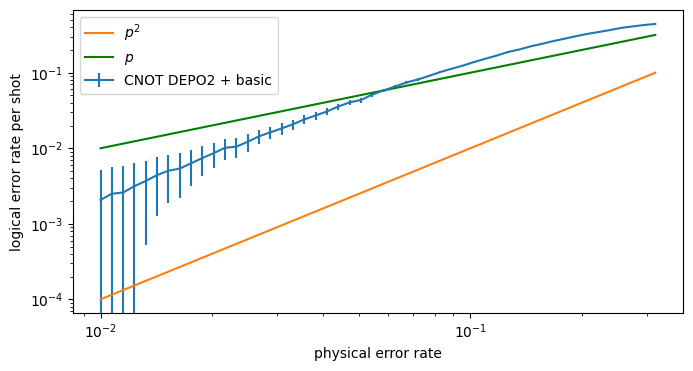

In [30]:
factory_set = [
    factory_steane_cnot_faults_and_basic
]

plot_factory_set(
    factory_set,
    num_shots=100_000,
    noise_set=np.logspace(-2,-0.5),
    filename="final_test_distance_3"
)